In [63]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
dataset_folder_name = "../input/utkface-new/UTKFace"

In [65]:
TRAIN_TEST_SPLIT = 0.7

In [66]:
IM_WIDTH = IM_HEIGHT = 198

In [67]:
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

In [68]:
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

In [69]:
 def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')            
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

In [70]:
def parse_dataset(dataset_path, ext='jpg'):     
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [71]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,26.0,male,asian,../input/utkface-new/UTKFace/26_0_2_2017010402...
1,22.0,female,black,../input/utkface-new/UTKFace/22_1_1_2017011223...
2,21.0,female,indian,../input/utkface-new/UTKFace/21_1_3_2017010500...
3,28.0,male,white,../input/utkface-new/UTKFace/28_0_0_2017011718...
4,17.0,female,others,../input/utkface-new/UTKFace/17_1_4_2017010322...


In [72]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [73]:
plot_distribution(df['race'])

In [74]:
plot_distribution(df['gender'])

In [75]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [76]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [77]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]        
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])        
        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0       
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):     
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break

In [78]:
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
    
    def build_race_branch(self, inputs, num_races):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)        
        return x  
    
    def build_gender_branch(self, inputs, num_genders=2): 
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)        
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)        
        return x  
    
    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, width, height, num_races):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)        
        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")        
        return model

In [80]:
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

In [81]:
init_lr = 1e-4
epochs = 80

In [82]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mae', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [83]:
!pip install livelossplot

In [84]:
from tensorflow import keras
model = keras.models.load_model("./Best_model_params.h5")


In [85]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
___________________________________________________________________________________________

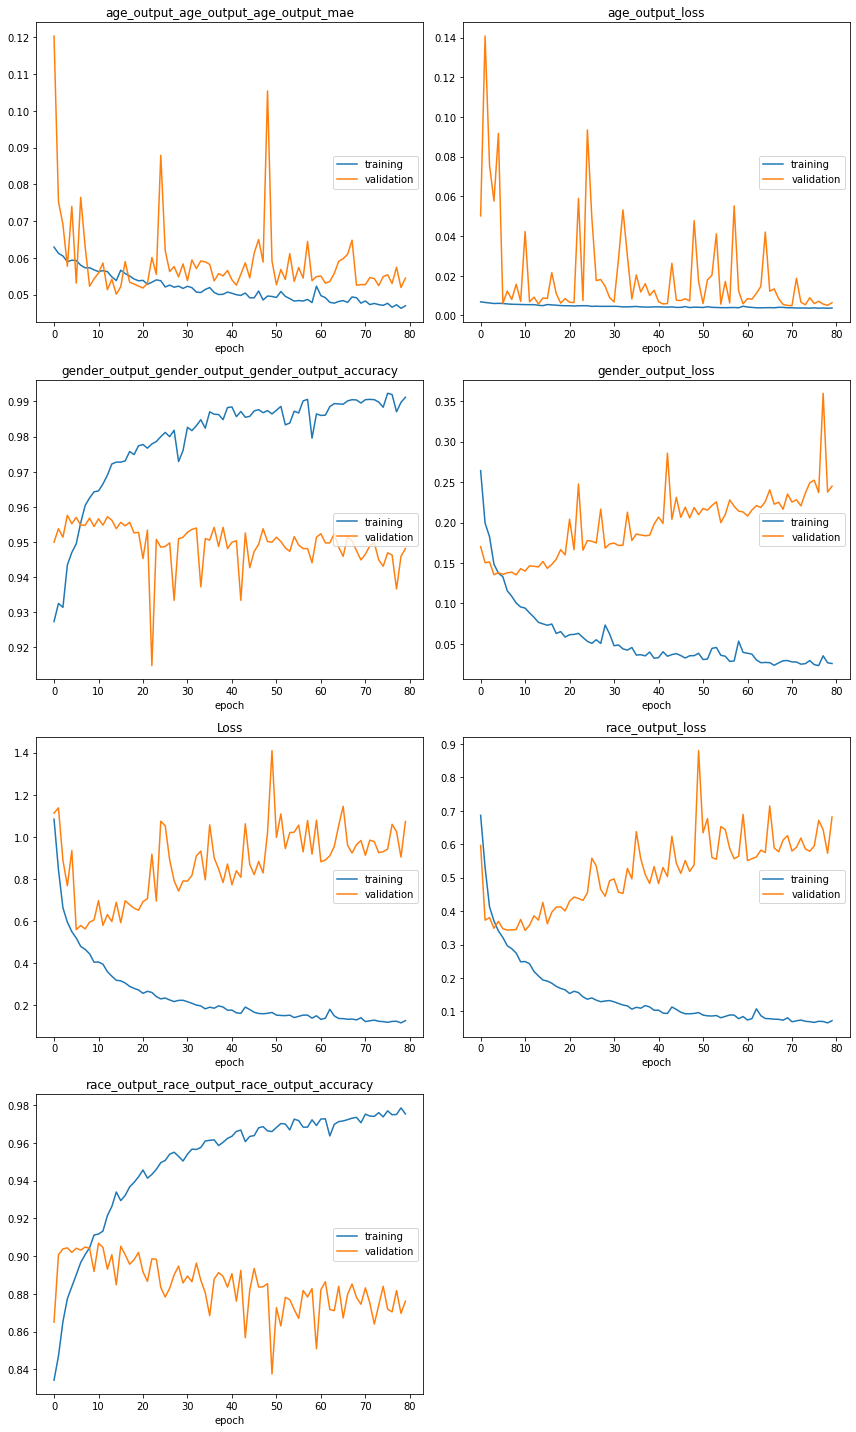

age_output_age_output_age_output_mae
	training         	 (min:    0.046, max:    0.063, cur:    0.047)
	validation       	 (min:    0.050, max:    0.120, cur:    0.054)
age_output_loss
	training         	 (min:    0.004, max:    0.007, cur:    0.004)
	validation       	 (min:    0.005, max:    0.141, cur:    0.006)
gender_output_gender_output_gender_output_accuracy
	training         	 (min:    0.927, max:    0.992, cur:    0.991)
	validation       	 (min:    0.915, max:    0.958, cur:    0.948)
gender_output_loss
	training         	 (min:    0.023, max:    0.264, cur:    0.026)
	validation       	 (min:    0.135, max:    0.360, cur:    0.245)
Loss
	training         	 (min:    0.115, max:    1.084, cur:    0.126)
	validation       	 (min:    0.559, max:    1.410, cur:    1.073)
race_output_loss
	training         	 (min:    0.065, max:    0.687, cur:    0.072)
	validation       	 (min:    0.342, max:    0.880, cur:    0.682)
race_output_race_output_race_output_accuracy
	training         

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKerasTF

batch_size = 42
valid_batch_size = 42

train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
checkpoint = ModelCheckpoint("Best_model_params.h5", monitor='val_loss')
callbacks = [PlotLossesKerasTF(), checkpoint]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

In [87]:
history.history

{'loss': [1.0838489532470703,
  0.8430579304695129,
  0.6627981066703796,
  0.5945743918418884,
  0.5491653084754944,
  0.5188098549842834,
  0.47910457849502563,
  0.4647318720817566,
  0.4439263343811035,
  0.40388673543930054,
  0.40498122572898865,
  0.39431047439575195,
  0.35888683795928955,
  0.3373090922832489,
  0.3178851008415222,
  0.315395325422287,
  0.30497488379478455,
  0.28902170062065125,
  0.2793676555156708,
  0.27189701795578003,
  0.2558489739894867,
  0.2654553949832916,
  0.26011979579925537,
  0.24055492877960205,
  0.2294398695230484,
  0.23364976048469543,
  0.2244061827659607,
  0.21668393909931183,
  0.2223338633775711,
  0.22292876243591309,
  0.2161344438791275,
  0.20838074386119843,
  0.20000211894512177,
  0.19612948596477509,
  0.18211208283901215,
  0.1900014579296112,
  0.18508869409561157,
  0.19632172584533691,
  0.19074010848999023,
  0.17560350894927979,
  0.17614176869392395,
  0.16332194209098816,
  0.16068896651268005,
  0.19053339958190918,


In [92]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_race_output_race_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_race_output_race_output_accuracy'],
                    name='Valid'))

fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [97]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_gender_output_gender_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_gender_output_gender_output_accuracy'],
                    name='Valid'))

fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [104]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_age_output_age_output_mae'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_age_output_age_output_mae'],
                    name='Valid'))

fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

<Figure size 432x288 with 0 Axes>

In [105]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))

fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [106]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

In [107]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [108]:
from sklearn.metrics import classification_report
cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.86      0.94      0.90      3024
       black       0.90      0.91      0.91      1342
       asian       0.92      0.89      0.91      1035
      indian       0.84      0.82      0.83      1152
      others       0.70      0.37      0.49       487

    accuracy                           0.87      7040
   macro avg       0.85      0.79      0.81      7040
weighted avg       0.86      0.87      0.86      7040



<AxesSubplot:>

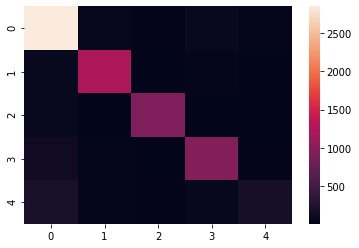

In [109]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(race_true, race_pred)
sns.heatmap(cm)

<AxesSubplot:>

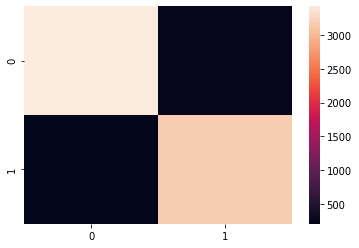

In [110]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(gender_true, gender_pred)
sns.heatmap(cm)

In [111]:
from sklearn.metrics import classification_report
cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.86      0.94      0.90      3024
       black       0.90      0.91      0.91      1342
       asian       0.92      0.89      0.91      1035
      indian       0.84      0.82      0.83      1152
      others       0.70      0.37      0.49       487

    accuracy                           0.87      7040
   macro avg       0.85      0.79      0.81      7040
weighted avg       0.86      0.87      0.86      7040



In [112]:
from sklearn.metrics import r2_score
print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  0.8143386299313022
